# Vertical Transects

This draft notebook plots the temperature conditions as a function of the x-coordinate and depth-coordinate, for each model at the end of the Ocean1 and Ocean2 runs.

Created by Dave Gwyther, edited by Claire Yung.

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
import cmocean as cm

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

Models: 
```
COCO   MITgcm-BAS          MITgcm-JPL  MOM6_SIGMA_ZSTAR  NEMO-CNRS      POP2x
FVCOM  MITgcm_BAS_Coupled  MOM6        MPAS-Ocean        NEMO-UKESM1is  ROMS-UTAS
```

In [2]:
## folder where the isomip-plus github repo is located
baserepo = '/g/data/x77/cy8964/isomip-plus/'
## folder where you downloaded the zipped Google Drive data
basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)

def get_labels(expt):
    '''
    Get labels of experiments
    Make some modifications to names
    '''
    labels = []
    for fileIndex in range(len(expt)):
        fileName = expt[fileIndex]
        baseName = os.path.basename(basedrive +fileName)
        modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
        if "COM" in fileName:
            #make edits to COM names
            if "MOM6" in fileName:
                if "SIGMA_ZSTAR" not in fileName:
                    modelName = modelName + '-LAYER'
            elif "ROMS" in fileName:
                modelName = "ROMS"
        elif "TYP" in fileName:
            # make edits to COM names
            if "MOM6" in fileName:
                modelName = modelName + '-LAYER'
            elif "CNRS" in fileName:
                if "TYPa" in fileName:
                    modelName = modelName + '-TYPa'
                elif "TYPb" in fileName:
                    modelName = modelName + '-TYPb'
            elif "tides" in fileName:
                modelName = "ROMS-tides"
            elif "ROMS" in fileName:
                modelName = "ROMS"
        labels.append(modelName.strip('V3').replace(" ", "-"))
    return labels


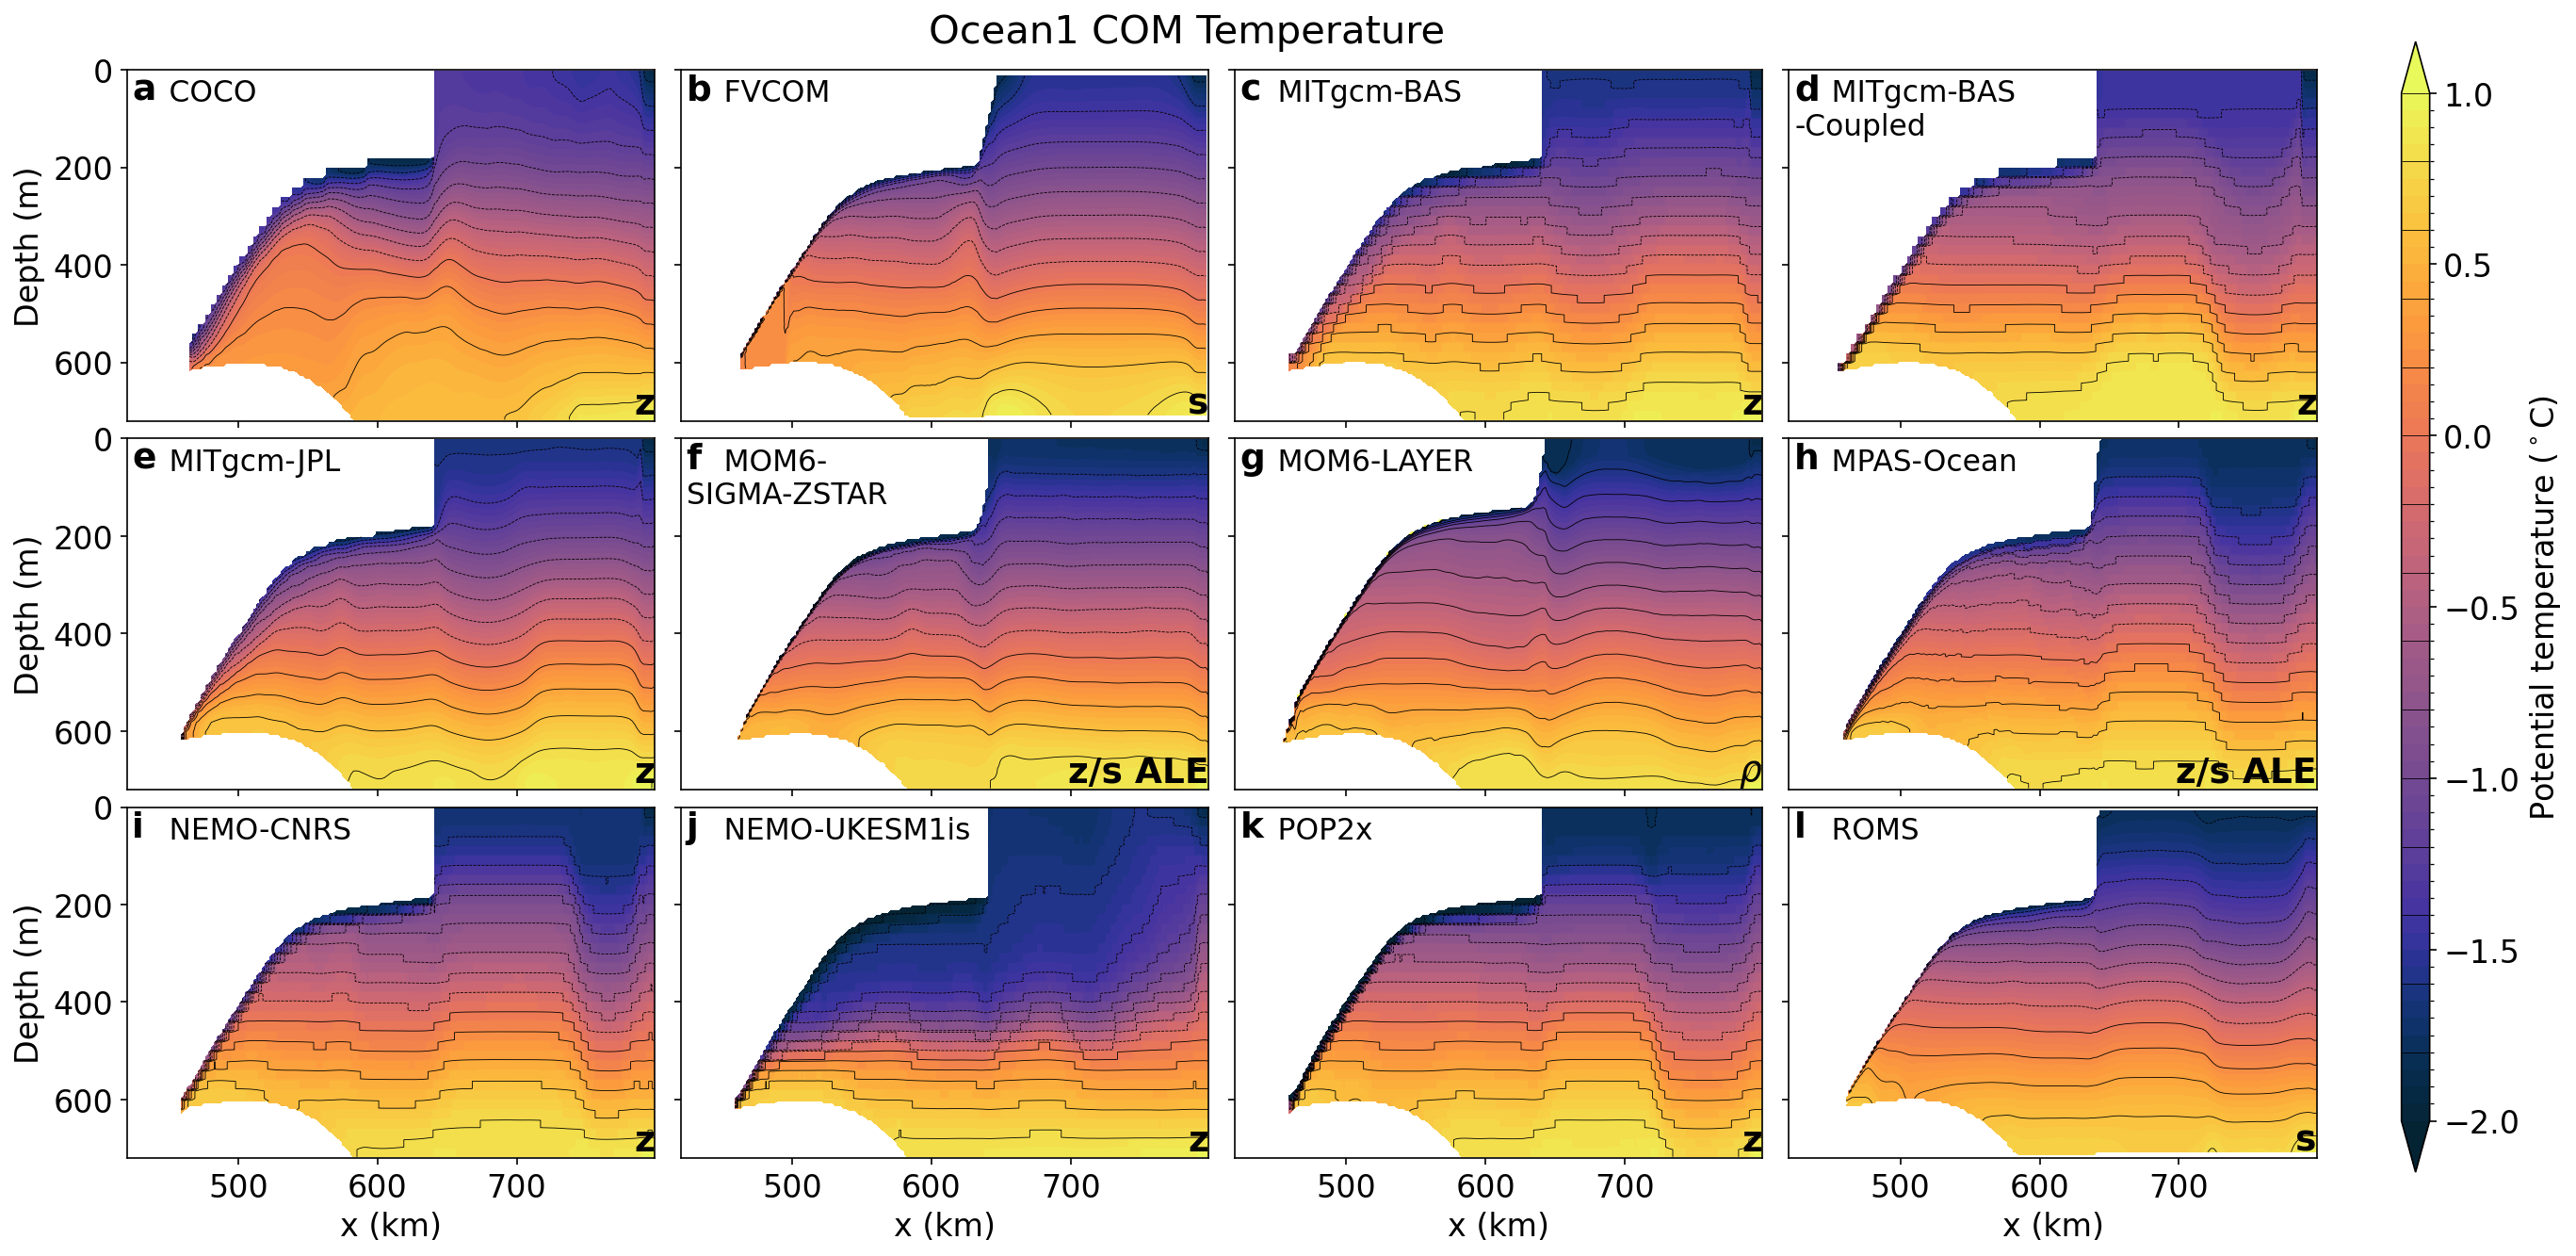

In [5]:
import matplotlib.gridspec as gridspec

expt = Ocean1_COM
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)

#Edit labels
labels[3]='MITgcm-BAS\n-Coupled'
labels[5]='MOM6-\nSIGMA-ZSTAR'

#Type of vertical coordinate
vert_coord_type = ['z','s','z','z','z','z/s ALE',r'$\rho$','z/s ALE','z','z','z','s']

time = 240
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # mr<1e36 is to get rid of NaNs.
    c = (var.where(var <1e36)).where(var.nx > 440).plot.contourf(cmap = cm.cm.thermal, levels = np.linspace(-2,1,61),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    ls = (var.where(var <1e36)).where(var.nx > 440).plot.contour( levels = np.linspace(-2,1,16), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=16)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=16)
    else:
        plt.xlabel('')
    plt.ylim(720,0)
    plt.xlim(420,799)
    t = plt.text(1,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
             fontweight='bold', va='bottom',color = 'k', ha = 'right')
#    t.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))
    plt.tick_params(labelsize=16)

cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax)
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16, )
cbar.ax.set_yticks(np.arange(-2,1.1,0.5)) 
cbar.add_lines(ls)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean1 COM Temperature', y = 0.92, fontsize = 20);

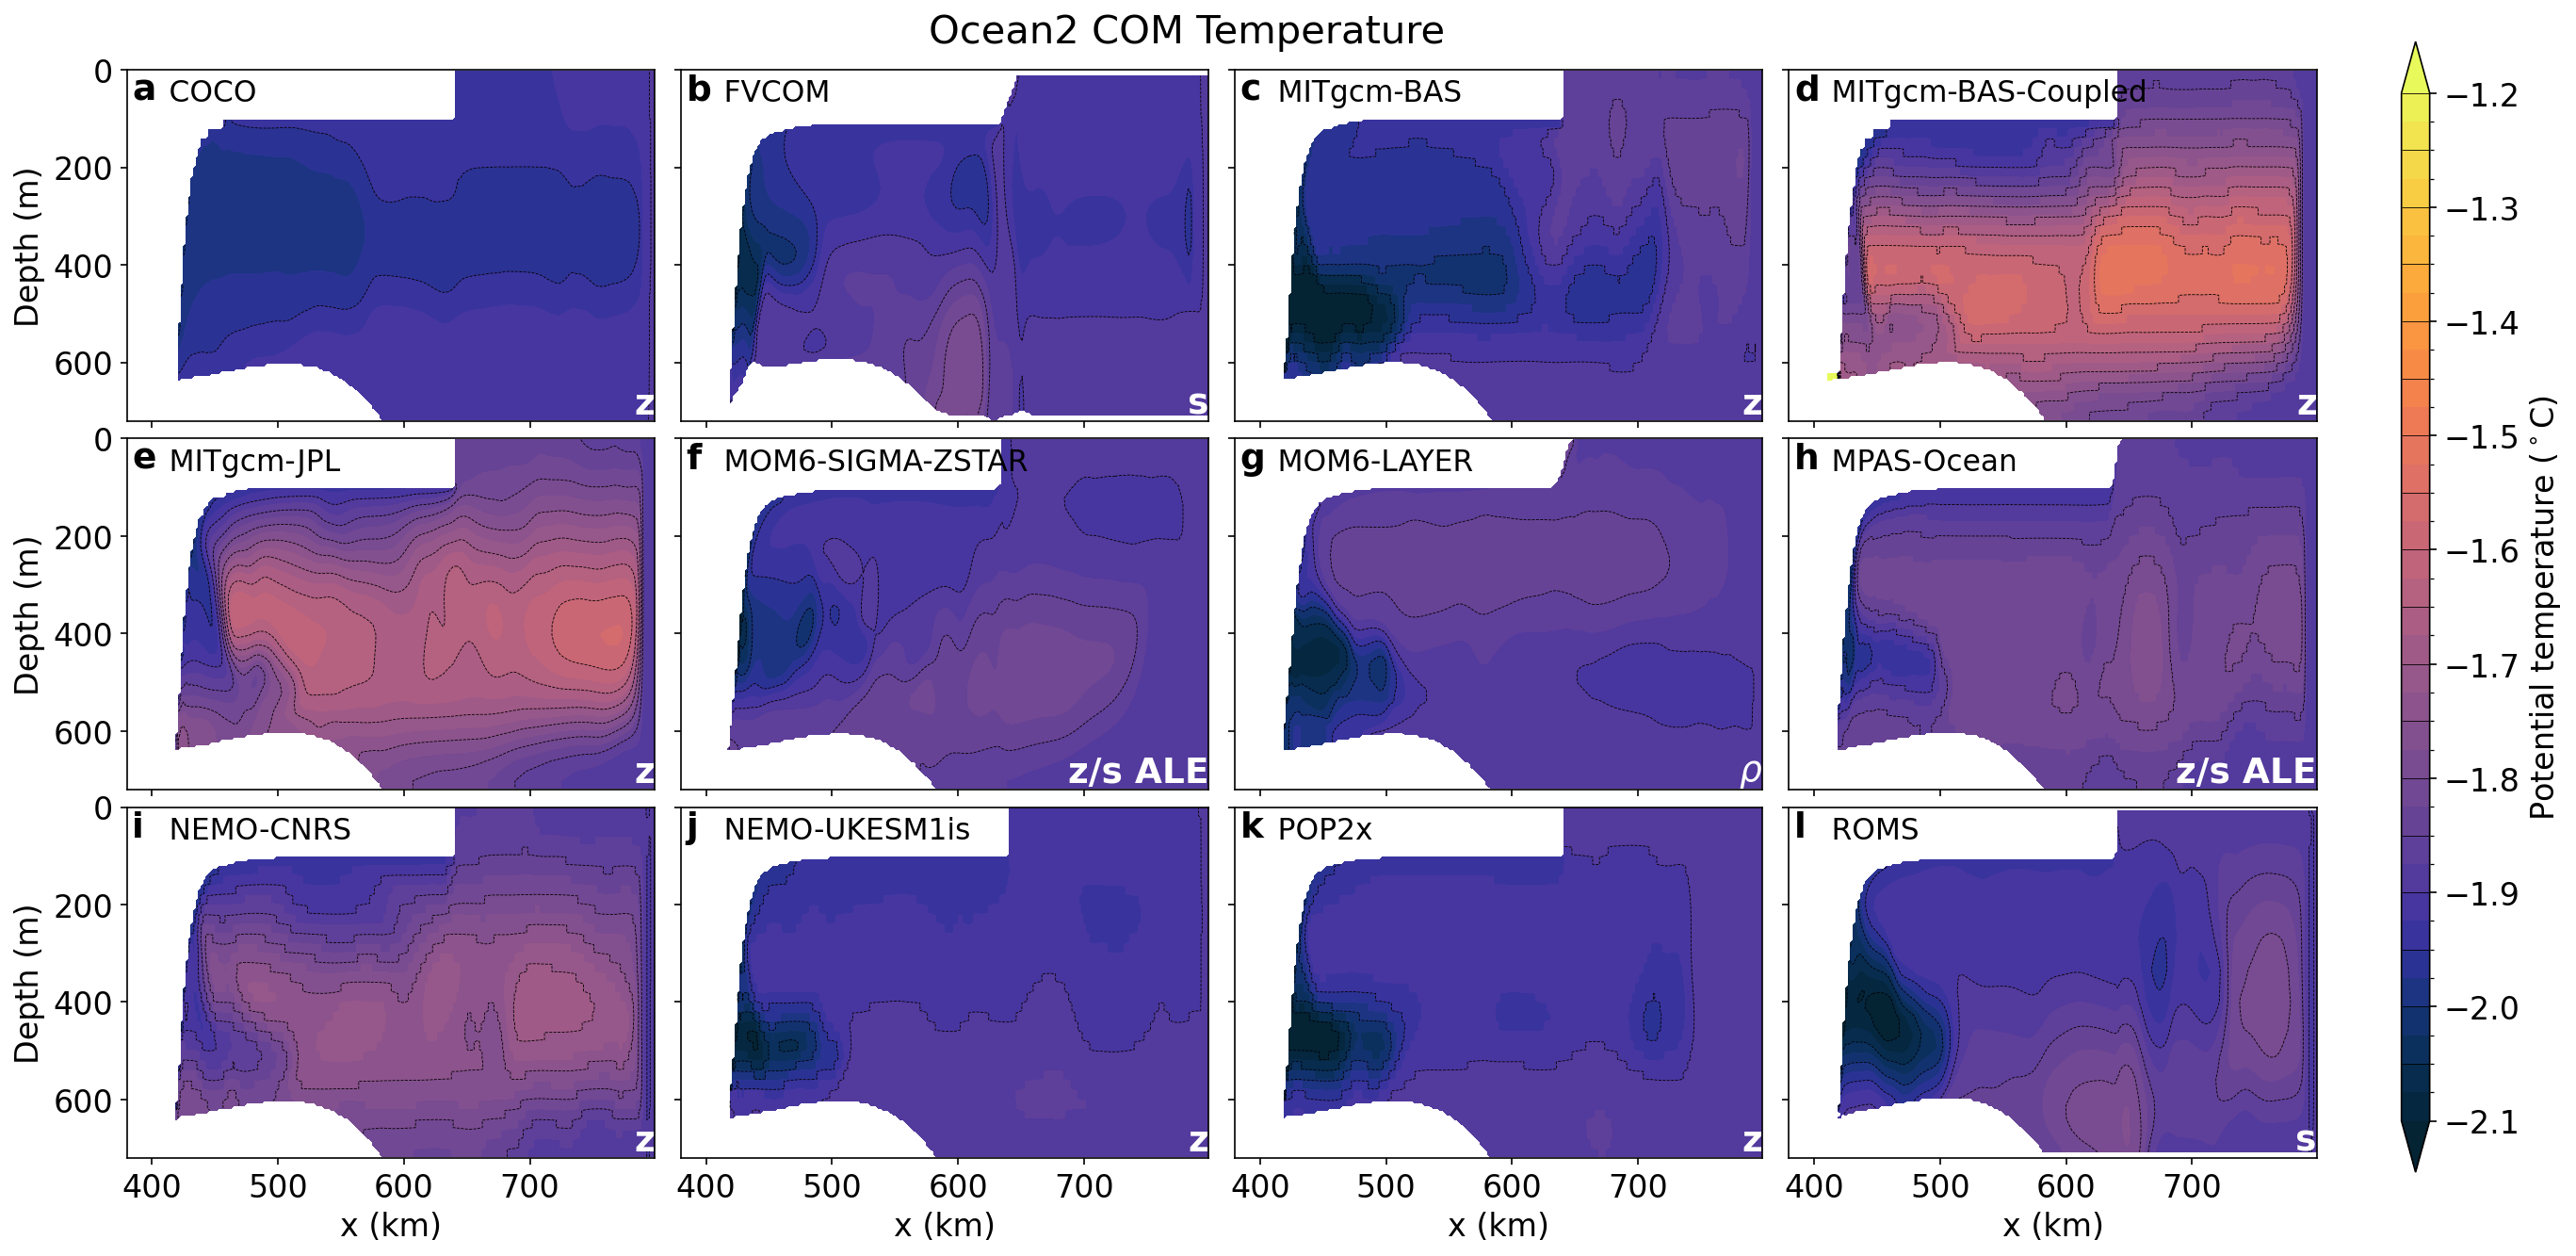

In [11]:
import matplotlib.gridspec as gridspec

expt = Ocean2_COM
labels = get_labels(expt)
length = len(expt)
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m']
ncols = int(np.ceil(length/3))

gs = gridspec.GridSpec(nrows=3,ncols=ncols,wspace=0.05, hspace=0.05)
fig = plt.figure(figsize=(20,10),facecolor='w',dpi = 150)

#Type of vertical coordinate
vert_coord_type = ['z','s','z','z','z','z/s ALE',r'$\rho$','z/s ALE','z','z','z','s']

time = 240
for i in np.arange(length):
    # ax = plt.subplot(3,nrows,i+1)
    ax=fig.add_subplot(gs[i])
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    var = data.temperatureXZ.isel(nTime = np.arange(time-13,time)).mean('nTime')
    # last year of time
    var['nz'] = var.nz*5+2.5 # add depth (2.5,7.5 etc)
    var['nx'] = var.nx*2+321
    # mr<1e36 is to get rid of NaNs.
    c = (var.where(var <1e36)).plot.contourf(cmap = cm.cm.thermal, levels = np.arange(-2.1,-1.19,0.025),extend = 'both',add_colorbar = False)#, cbar_kwargs = {'label':'Overturning \n Streamfunction (Sv)'},extend = 'both')
    ls = (var.where(var <1e36)).plot.contour( levels = np.arange(-2.1,-1.19,0.05), colors = 'k', linewidths = 0.4)
    plt.text(0.01,0.99,alphabet[i], fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
    plt.text(0.01,0.975,'    '+labels[i], fontsize = 15, transform=ax.transAxes, va='top')
    # ax.grid()

    if (i==1) or (i==2) or (i==3) or (i==5) or (i==6) or (i==7) or (i==9) or (i==10) or (i==11):
        ax.set_yticklabels([])
    if (i<8):
        ax.set_xticklabels([])
        
    if (i==0) or (i==4) or (i==8):
        plt.ylabel('Depth (m)',fontsize=16)
    else:
        plt.ylabel('')
    if i>=8:
        plt.xlabel('x (km)',fontsize=16)
    else:
        plt.xlabel('')
    plt.ylim(720,0)
    plt.xlim(380,799)
    t = plt.text(1,0,vert_coord_type[i], fontsize = 18, transform=ax.transAxes, 
             fontweight='bold', va='bottom',color = 'w', ha = 'right')
    plt.tick_params(labelsize=16)



cax = plt.axes([0.93,0.1,0.01,0.8])
cbar = plt.colorbar(c, cax = cax, ticks = np.arange(-2.1,-1.19,0.1))
cbar.ax.set_ylabel(r'Potential temperature ($^\circ $C)', fontsize = 16)
cbar.add_lines(ls)
plt.tick_params(labelsize=16)

fig.suptitle('Ocean2 COM Temperature', y = 0.92,fontsize = 20);